# Recreating ROTMOD for 5533
### Gipsy inputs: ZLAW=sech-squared, Z0=.93[kpc],DISTANCE=16.5[Mpc], DENSITY FILE: *call density file* units of: [kpc,mag/arcsec**2] or [kpc,Msun/pc**2], RADDENS=*define radius range* 


In [1]:
# Import
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

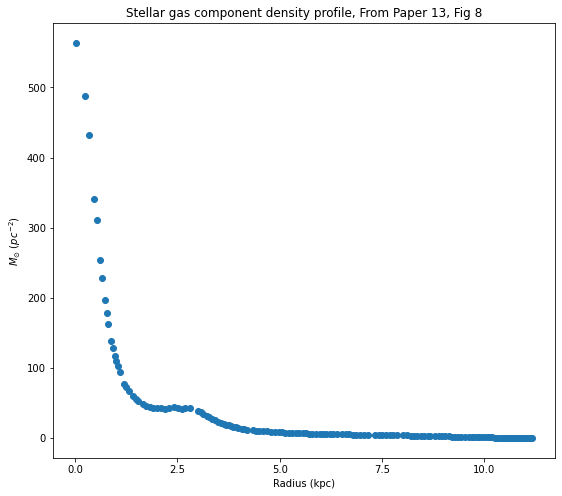

In [2]:
# According to Noordermeer's email: 
   # "For the contribution of the stars (bulge + disk), I used the 
   # R-band photometry published in Noordermeer & Van der Hulst (2007 - MNRAS 376; p1480). 
   # Again, I believe there was a tool (perhaps the same one as for the gas disk) 
   # in GIPSY to convert this into a rotation curve, but I'm afraid I can't recall the details."

# Used DataThief to get data from image
densitydata = np.loadtxt("../data/gasmsd_kpc_linear.txt")   #gas density file [kpc, Msun/pc**2]
dgasr, dgas = densitydata.T

# Plot R-band photometry to make sure data was traced right
plt.figure(figsize=(9,8))
plt.scatter(dgasr,dgas)
plt.title("Stellar gas component density profile, From Paper 13, Fig 8")
plt.rcParams.update({'font.size': 30})
plt.xlabel("Radius (kpc)")
plt.ylabel("$M_{\odot}$ ($pc^{-2}$)")
plt.show()

In [3]:
## INPUTS:
z0 = 0.93                  #'vertical scale height [kpc]'   # still can't figure out how they got this number...
D = 16.5             #Galaxy distance from earth [Mpc], is it 16.5 or 16.9???????
densitydata = np.loadtxt("../data/gasmsd_kpc_linear.txt")   #gas density file [kpc, Msun/pc**2]
densityr, density = densitydata.T

rawtotaldata = np.loadtxt("../NGC_5005/traced_data/ngc5005_data.txt")  #"raw" total rotation curve data points
rawr,rawv,rawe1,rawe2 = rawtotaldata.T #extracting the array of radius points, rawr, to fit component to
print(rawr)

[ 0.      0.409   0.9156  1.3932  1.8693  2.3606  2.8376  3.3282  3.8209
  4.2956  4.7746  5.5897  6.3896  7.1896  7.9893  8.7894  9.6049 10.4203
 11.1894]


In [4]:
# NECESSARY CONSTANTS
G = 0.00000431158              # gravitational constant (kpc/solar mass*(km/s)^2)


                               # note: The integration in Z is the most time consuming part
                               # of the calculation. For example it takes about 0.2 seconds
                               # to calculate a point on the rotation curve for a disk with zero
 
h=8.9#?????          
dens0 = 0.31e9  #?????               # central density of exponential DISK in solar masses per square parsec
rcut = 4*h                     # cutoff radius

delta = 0.2*h  #?????                # softening parameter of DISK in kpc [0.0]. It may be wise
                               # to have a non-zero softening in case of a truncated disk, 
                               # because then the sharp features in the calculated rotation 
                               # curve will be smoothed out. A softening parameter of about 
                               # 0.2 scale lengths would be sufficient.
                
LEN1 = 20016
LEN2 = 40001

#LEN2 = len(rkpc)              
CONSTANT = 2.0 * np.pi * G / 3.0
EPS = 0.000001

naccur = 1                     # GUESS -> accuracy of calculations, range between 1-10, 
                               # The programme needs more time for higher accuracies. 
                               # If no ZLAW is specified, the accuracy parameter is always 10.

#radii = np.linspace(0,100,500)    # GUESS -> sampling radii
radii = rawr                   # GUESS -> sampling radii
R = lambda h: 4*h

In [5]:
# Definitions
def func(x,y,z):
    if( x==y ) & ( z == 0):
        r = 0
    elif( x==0 ) | ( y == 0):
        r = 0
    else:
        xxx = (x*x + y*y + z*z) / (2.0 * x * y)
        rrr = (xxx*xxx - 1.0)
        ppp = 1.0 / (xxx + np.sqrt(rrr))
        fm = 1.0 - ppp*ppp
        el1 = (1.3862944 + fm * (0.1119723 + fm * 0.0725296)) - (0.5 + fm * (0.1213478 + fm * 0.0288729)) * np.log(fm)
        el2 = (1.0 + fm * ( 0.4630151 + fm * 0.1077812 ) ) - (fm * (0.2452727 + fm * 0.0412496)) * np.log(fm)
        r = ((1.0 - xxx * y/x) * el2 / (rrr) + (y/x - ppp) * el1 / np.sqrt(rrr)) / np.pi
        r *= np.sqrt(x / (y * ppp))
    return r

In [6]:
# DISK Density distribution 
# There are three distribution laws possible; 
# the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)**2/Z0,
# an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 
# a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI. 

# case 1 is a flat disk, z0 = 0

# Sech-squared law:
def denzed_case2(z,z0): 
    r = np.cosh(z / z0)
    r = r * r * z0
    r = 1.0 / r
    return r

# Exponential:
def denzed_case3(z,z0):
    r = np.exp(-z / z0) /z0
    return r

# Simple-sech
def denzed_case4(z,z0):
    r = 2 / z0 / np.pi / np.cosh(z/z0)
    return r

def denzed(z,z0,mode):
    #mode = input("Which Z density law? 2 or 3 or 4: ")
    #The above results in the user being asked for every point entered; this was likely used as a backend.
    if mode == 2:
        return denzed_case2(z,z0)
    if mode == 3:
        return denzed_case2(z,z0)
    if mode == 4:
        return denzed_case4(z,z0)
    else:
        return np.nan
        print("Error occured in denzed; no mode selected. Returned nan.")

In [7]:
"""intzed computes the integral over Z that defines the kernel of the integral formula for the rotation velocity. 
This is done for an arbitrary vertical density profile, specified in the function denzed.
The interval of integration is divided into several subintervals, in each of which Simpson's rule is used. 
It is thus possible to have different steps in different regions of the interval of integration, 
and to compute the integral more accurately. An attempt has been made at optimizing the subdivision. 
It is still possible that the kernel is not accurate, especially when R is very close to U. 
It is NOT recommended that the programme is used with very small, but non-zero, values of the thickness. 
On the other hand, the situation with an infinitely thin disk is dealt with properly, the density profile in 
Z being then treated as a Dirac delta function."""

def intzed(r,u,z0,naccur,mode):
    zeds = np.array([0.02, 0.50, 1.00, 3.00, 10.00])
    
    if (z0 != 0.0) & (naccur != 0):
        n = 10
        n = naccur * n
        
        if (np.abs(r - u) <= (0.2 * z0)) & (naccur > 1):
            n = 200
        
        zne = 0.0
        res = 0.0
        i = 0
        while i < 5: 
            zol = zne
            zne = zeds[i] * z0
            step = (zne - zol) / n
            z = zol
            res += step * func(r,u,z) * denzed(z,z0,mode) / 3.0
            w = 4.0 / 3.0         
            j = 0.0
            while j < n:
                z += step
                res += step * func(r,u,z) * denzed(z,z0,mode) * w
                w = 2.0 - w
                j += 1
            res -= step * func(r,u,z) * denzed(z,z0,mode) / 3.0
            i += 1
    else:
        res = func(r,u,z0)
    return res

In [8]:
# interp does a Lagrange interpolation (second order)
def interpd(x1,y1,n1,x2,y2,n2):
    i = 0
    j = 1
    done = 0
    n1 = len(radii)
    n2 = len(radii)

    while i < n2:
        x = x2[i]
        y = 0.0
        while (j != done) & (j < (n1 - 1)):
            if ((x1[j-1] <= x ) & (x1[j+1] >= x)):
                k = j - 1
                while (k <= j + 1):
                    f = 1.0
                    l = j - 1
                    while l <= j + 1:
                        if (l != k):
                            f *= (x - x1[l]) / (x1[k] - x1[l])
                        l += 1        
                    y += f * y1[k]
                    k += 1 
                done = 1
            j += 1
        if (y > 0.0):
            y2[i] = y
        else: 
            y2[i] =0.0
        i += 1

In [9]:
# interg does the integration
def interg(xd,yd,nd,r,rstart,z0,step,ndens,naccur,mode):
    vsq = 0.0
    i = 1
    k = 0

    while k < ndens:
        if (k == 0 or k == (ndens - 1)):
            iw = 1
        else:
            iw = 4 - 2 * ((k + 1) % 2)
        
        x = rstart + step * k
        y = 0.0

        if (x < xd[nd-1]): 
            done = False
            while (done == False) & (i < (nd - 1)):
                #if i==1:
                    #print("            Checking xd...") #This if (xd...) loop is entered many times in quick succession; doesn't seem to be hanging so much as running too much. Not seeing the "increased i for the first time" as frequently as I would have expected, but this if statement IS completing quickly.
                if (xd[i-1] <= x) & (xd[i+1] >= x):
                    k1 = i - 1
                    while k1 <= (i + 1):
                        f = 1.0
                        k2 = i - 1
                        while k2 <= (i + 1):
                            if (k1 != k2):
                                f *= (x - xd[k2]) / (xd[k1] - xd[k2])
                            k2 += 1
                        y += f * yd[k1]
                        done = True
                        k1 += 1
                else:
                    i += 1
            if (y > 0.0):
                res = intzed(r,x,z0,naccur,mode)
                vsq += CONSTANT * res * y * step * iw
        k += 1
    return vsq

In [10]:
# Surface densities are used to calculate the disk mass
# It asks for an array of surface densities and radii
# I'll just guess the disk mass instead to make this simpler, since I don't have those arrays

#xdinp = np.array(0,100,500)        # radii surface density
#ydinp =                            # surface densities

rdinp = rcut + delta               # max radius, where galaxy ends
ndinp = LEN2 - 1                   # number of surface densities
ydinp = np.zeros(LEN2)
xdinp = np.zeros(LEN2)
xstep = rdinp / (ndinp - 1)        # step in radius

# counter 
i = 0
while i < ndinp:
    xdinp[i] = x = xstep * i
    if ((x >= rcut) & (delta > 0.0)):
        y = dens0 * np.exp(-rcut / h) * (rcut + delta - x) / delta
    if (x >= rdinp):
        y = 0.0                 # end of disk
    else:
        y = dens0 * np.exp(-x / h) # exponential disk
    ydinp[i] = y
    i += 1


# Next step here would be: "Now try to fit an exponential and fit H and DENS0."
# And: "Now we determine the disk mass and allow the user to modify it."

# But I will just guess it for now. Not sure where we need this
dkmass = 1e9

In [11]:
# now get radii for which we should calculate the rotation curve.
# using rings?
# this is a whole new calculation so I'm guessing again

nring = len(radii)              # number of sampling radii
rings = radii
ntimes = 10                     # this one is given: accuracy multiplication factor

In [12]:
"""# Since the surface densities are not given, I'm using Casertano's density function 
# to define radii and densities

# Density piecewise function
def rho0(r,h,rho00):
    condlist = [r <= R(h), (r > R(h)) & (r <= (R(h)+delta)), r > (R(h)+delta)]
    funclist = [lambda r: rho00*np.exp(-r/h), 
                lambda r: rho00*np.exp(-R(h)/h)*(1-(r-R(h))/delta), 
                lambda r: 0]
    pieces = np.piecewise(r, condlist, funclist)
    return pieces

xdinp = radii
ydinp = rho0(radii,h,dens0)"""

"# Since the surface densities are not given, I'm using Casertano's density function \n# to define radii and densities\n\n# Density piecewise function\ndef rho0(r,h,rho00):\n    condlist = [r <= R(h), (r > R(h)) & (r <= (R(h)+delta)), r > (R(h)+delta)]\n    funclist = [lambda r: rho00*np.exp(-r/h), \n                lambda r: rho00*np.exp(-R(h)/h)*(1-(r-R(h))/delta), \n                lambda r: 0]\n    pieces = np.piecewise(r, condlist, funclist)\n    return pieces\n\nxdinp = radii\nydinp = rho0(radii,h,dens0)"

In [13]:
# Calculation
print("Setting variables...")
i = 0
j = 0
velocs = np.zeros(len(radii))
nradii = len(radii)
densit = np.zeros(LEN1+LEN2+1)

#####################################
########### USER SETTINGS ###########
#####################################
mode = 2

print("Variables set. Interpolating...")
interpd( xdinp, ydinp, ndinp, radii, densit, nradii )

print("Interpolation complete. Calculation will now begin.")
while i < len(radii):
    r = radii[i]
    vsq = 0.0

    if i==0:
           print("Loop variables set. Setting variable j...")
    while ((j < nring)&(rings[j] < r)):
           j += 1

    if i==0:
       print("Initial value of j set to "+str(j)+". Setting additional variables...")
    skip = rings[j] != r
    z1 = z0
    r1 = r - 3.0 * z1
    if r1 < 0.0:
           r1 = 0.0
    r2 = 0.0

    if (r1 < (rcut + 2.0 * delta)):
        r2 = r + (r - r1)
        ndens = 6 * ntimes + 1
        step = (r2 - r1) / (ndens - 1)
        rstart = r1
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur,mode)
        
        if r1 > 0.0:
            ndens = r1 * ntimes / h
            ndens = 2 * (ndens - 1)
            rstart = 0.0
            vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur,mode)
    if r2 < (rcut + 2.0 * delta):
        ndens = (rcut + 2.0 * delta - r2) * ntimes / h
        ndens = 2 * (ndens / 2) + 3
        step = (rcut + 2.0 * delta - r2) / (ndens - 1)
        rstart = r2
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,naccur,mode)
    if vsq < 0.0:
           velocs[i] = (-np.sqrt(-vsq))
    else:
           velocs[i] = (np.sqrt(vsq))

    print("{:10.1f}".format(i/len(radii)*100)+"% Complete",end="")
    print('\r',end="")
    i += 1

Setting variables...
Variables set. Interpolating...
Interpolation complete. Calculation will now begin.
Loop variables set. Setting variable j...
Initial value of j set to 0. Setting additional variables...


<ipython-input-5-f42b30e48f33>:12: RuntimeWarning: divide by zero encountered in log
  el1 = (1.3862944 + fm * (0.1119723 + fm * 0.0725296)) - (0.5 + fm * (0.1213478 + fm * 0.0288729)) * np.log(fm)
<ipython-input-5-f42b30e48f33>:13: RuntimeWarning: divide by zero encountered in log
  el2 = (1.0 + fm * ( 0.4630151 + fm * 0.1077812 ) ) - (fm * (0.2452727 + fm * 0.0412496)) * np.log(fm)
<ipython-input-5-f42b30e48f33>:13: RuntimeWarning: invalid value encountered in double_scalars
  el2 = (1.0 + fm * ( 0.4630151 + fm * 0.1077812 ) ) - (fm * (0.2452727 + fm * 0.0412496)) * np.log(fm)


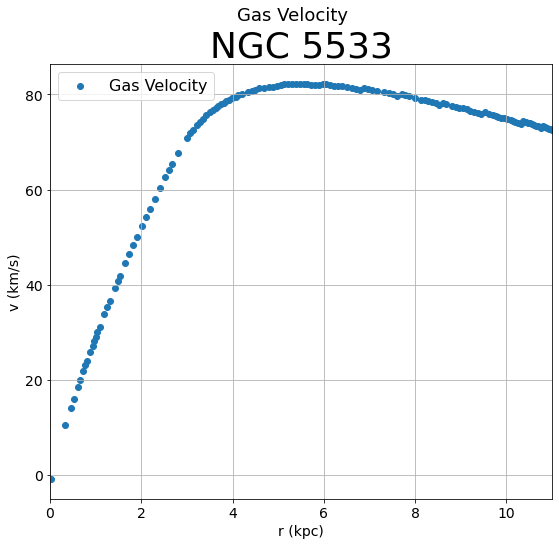

In [14]:
#plot disk velocity
fig = plt.figure(figsize=(9.0,8.0))                #size of the plot
ax = plt.axes()
ax.grid(True)
ax.yaxis.grid(True,which='minor',linestyle='--')

plt.scatter(radii, velocs, linestyle='solid', label='Gas Velocity')

plt.axis('tight');

fig.suptitle('Gas Velocity', fontsize=18)
ax.set(title='NGC 5533')              #labeling axes
ax.set_xlim(0,11)
ax.set_xlabel('r (kpc)', fontsize=14)
ax.set_ylabel('v (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend(fontsize=16);                                   #adding legend
#plt.savefig('DiskVelocity100pts.png')
plt.show()